# Handwritten Digit Recognition
#### Adam Finer, James Gibson, Johnathon Hein
https://github.com/jcolemang/HandwritingClassification.git


### Table of Contents
 
 * [Executive Summary](#Executive-Summary)
 * [Project Objectives and Introduction](#Project Objectives and Introduction)
 * [Data Preprocessing](#Data Preprocessing)
 * [Analysis](#Analysis)
 * [Links](#Links)
 * [Supplement](ProjectReportSupplement.ipynb) 


### Executive Summary
We wanted to do a project that involved image processing, advanced machine learning, and was applicable to a real world problem. As our interest in preprocessing was limited we found a project with readily accessible and clean data. As such we chose to create a web application in which we take in handwritten numerical user data and classify their input. We chose to implement most of our methods on our own to supplement our learning and to best understand what is actually going on. 

* We implemented our own three layer logistic-softmax neural network
* We implemented our own dbscan algorithm as a c extension
* We compiled our methodologies into a single python/c program using pygame
* We got our program working as a web-based application

### Project Objectives and Introduction

Our major objectives were as follows:

* Be able to recognize handwritten digits with 97.5%
* Have multiple datasets to use for both training and testing
* Have a simple self-contained application for handwritten digit recognition
* Implement a neural network

We made good progress in every category however did not use multiple datasets and did not achieve 97.5% accuracy in our final program taking in new input. Our application was mostly self-contained but did still rely on several external libraries. 

Our basic method of turning user input into a classified digit was:
* Take in mouse input with pygame
* Filter out the black pixels of the display
* Cluster these pixels using dbscan
* Place each cluster into a PIL image and resize the image
* Turn each PIL image into a numpy array
* Classify each array using a neural network

Shortly in to the project we had all of this working on a basic level. However, we found that a python implemented dbscan algorithm was prohibitavely slow. Wishing to learn more about the workings of these algorithms we decided to create our own implementation using a C extension module. Furthermore, we decided to implement a KD-Tree to reduce the number of calculations needed between nodes. There were several difficulties to this approach. One obvious problem with this approach is that python types need to be converted to C types for it to work. This required downloading a python developer package to access C function to convert the types for us. We used the Python-C-API. It required an annoying number of lines of code but it was a relatively simple process and the actual time overhead was on the scale of about 10 milliseconds (see [extension.c](extension.c)). C itself was another interesting problem. Being python programmers we were not accustomed to the care required for memory allocation and the lack of bounds checking. Luckily writing the code got easier as we progressed and we ended with a working kd tree DBScan implementation.

One choice made in the implementation of the tree was to use a sample when determining the median instead of sorting the entire data set. Because only a small sample has to be sorted we can avoid the repeated O(n\*log(n)) operation while splitting the data. While this certainly means the tree will not be optimal the reasoning is that traversing additional levels will be less costly. We have not carried out any tests to verify this.


### Data Preprocessing
For our data sets, we collected data from three sources: the kaggle mnist database, the complete mnist database from  http://pjreddie.com/projects/mnist-in-csv/, and the semeion database from https://archive.ics.uci.edu/ml/datasets/Semeion+Handwritten+Digit. The kaggle dataset was in a form where one row contained all the values, per pixel, of the 28x28 images of handwritten numbers. Each value was from 0 to 255, but we made it instead go from 0 to 1. The complete mnist database was in the same format, but did not contain column headers, so we transformed it properly. The semeion data base was in a format that contained 16x16 images and instead of integer row labels, it had binary row labels (001000000 means 3). So this data was also transformed.

### Analysis



Below is some analysis on the speed of both our python and c dbscan methods. The C method averaged around 500x faster although it was not tested on a variety of data. In reality this gap would actually be much higher. The data points we generated was relatively dense, meaning the kd tree was looking at more data points. Given sparse data a kd tree would be able to eliminate most of it with few comparisons while our python implementation was calculating the distance from every point to every other no matter the density.

In [1]:
import matplotlib
import pandas as pd
import numpy as np
%matplotlib inline

c_data = pd.read_csv('benchmark_c_only')
data = pd.read_csv('c_vs_python_benchmark')

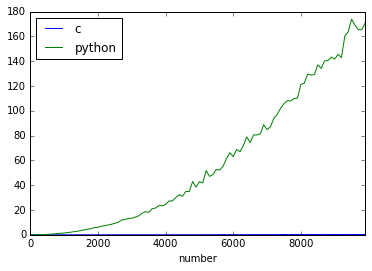

In [2]:
data.plot(x='number')

The jumps in the time could have been caused by several things. First, that the sampling when constructing the kd tree resulted in a highly skewed tree which could be disasterous to our runtimes if it were bad enough. Second, I believe that the jumps could be a result of the my operating system allowing another program to run. The timing method used did not take this in to account. Given the small scale of this data this would be easy to notice. This noise would be smoothed out by the larger scale of the python version's run time.

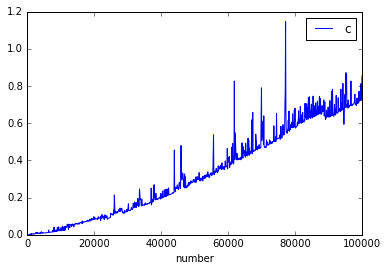

In [3]:
c_data.plot(x='number', y='c')

The below two graphs show the difference in Python and C runtimes with one single cluster and many separate clusters. The difference in Python runtimes is not particularly interesting and is merely a reflection of combining clusters in a silly way (along with other numerous inefficiencies). The difference in C runtimes is more interesting. With one single huge cluster the Kd tree does not eliminate many points and so it is essentially the same as the $n^2$ approach. With many clusters we take full advantage of the tree and barely need any actual comparisons.

Note that for each iteration the same points were clustered five times for both the clustering methods to reduce noise, resulting in the higher than normal run times. 

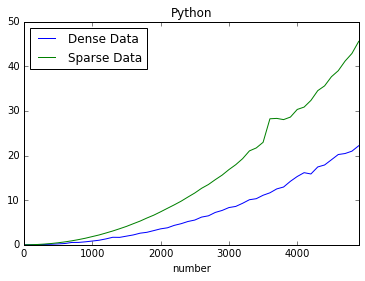

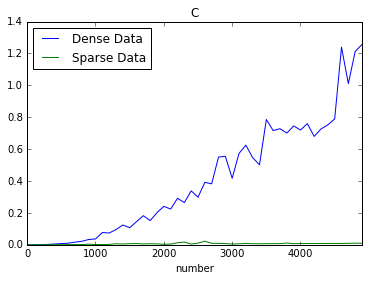

In [4]:
dense_cluster_data = pd.read_csv('BenchmarkingData/100cpython')
dense_cluster_data.set_index('iterations', inplace=True)
sparse_cluster_data = pd.read_csv('BenchmarkingData/100000000cpython')
sparse_cluster_data.set_index('iterations', inplace=True)
plt1 = dense_cluster_data.plot(x='number', y='py_time', label='Dense Data', title='Python')
plt2 = dense_cluster_data.plot(x='number', y='c_time', label='Dense Data', title='C')
sparse_cluster_data.plot(x='number', y='py_time', ax=plt1, label='Sparse Data', title='Python')
sparse_cluster_data.plot(x='number', y='c_time', ax=plt2, label='Sparse Data', title='C')

### Results

After switching between several models including random forests, extra random forrests, and neural networks we ended up setting on the neural network model described in the section below.



#### Final Neural Network Model
756-1024-1024-1024-10 Logistic-Softmax fully-connected feed-forward neural network model

This model acheived a testing error of 1.581%.

[Neural Network Model Results](NeuralNetwork.ipynb)

### Links

[KD Tree Implementation](kd_tree.c)

[DBScan Implementation](dbscan.c)

[Python to C wrapper](extension.c)

[Interfacing with C by Valentin Haenel](http://www.scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html#id1)



